In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 38.2 MB/s 
     |████████████████████████████████| 2.2 MB 54.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [ ]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [ ]:
# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head()

,file_name,normalized_transcription
0,LJ025-0131,and the lobes of the leaf instantly close toge...
1,LJ017-0144,There was no convincing proof that the accused...
2,LJ001-0143,For where these are boldly and carefully desig...
3,LJ049-0056,The first duty of the agents in the motorcade ...
4,LJ004-0158,All were in ill health; almost all were in rag...


In [ ]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size training set: {len(df_train)}")
print(f"Size validation set: {len(df_val)}")

Size training set: 11790
Size validation set: 1310


In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [ ]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256

# An integer scalar Tensor. The number of samples to step.
frame_step = 160

# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

In [ ]:
def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################

    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")

    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)

    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)

    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )

    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Process the label
    ###########################################

    # 7. Convert label to Lower case
    label = tf.strings.lower(label)

    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [ ]:
BATCH_SIZE = 32

In [ ]:
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
    )

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [ ]:
# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
    )

validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

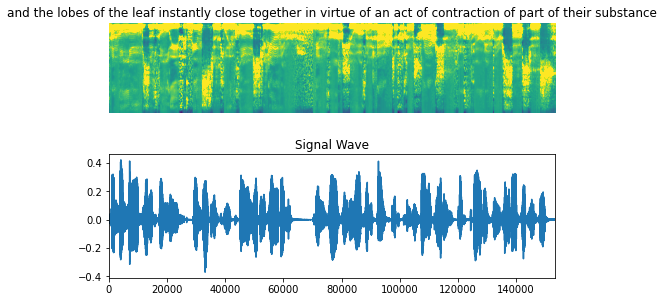

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()


In [ ]:
def CTCLoss(y_true, y_pred):
  # Compute the training-time loss value
  batch_length = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_length, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_length, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128, dropout_rate=0.5):
  """Model similar to DeepSpeech2."""

  # Model's input
  input_spectrogram = layers.Input((None, input_dim), name="input")

  # Expand the dimension to use 2D CNN.
  x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

  # Convolution layer 1
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 41],
      strides=[2, 2],
      padding="same",
      use_bias=False,
      name="conv_1")(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)

  # Convolution layer 2
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 21],
      strides=[1, 2],
      padding="same",
      use_bias=False,
      name="conv_2")(x)
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)

  # Reshape the resulted volume to feed the RNNs layers
  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

  # RNN layers
  for i in range(1, rnn_layers + 1):
      recurrent = layers.GRU(
          units=rnn_units,
          activation="tanh",
          recurrent_activation="sigmoid",
          use_bias=True,
          return_sequences=True,
          reset_after=True,
          name=f"gru_{i}",
      )
      x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", 
                                merge_mode="concat")(x)
      if i < rnn_layers:
          x = layers.Dropout(rate=0.5)(x)

  # Dense layer
  x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
  x = layers.ReLU(name="dense_1_relu")(x)
  x = layers.Dropout(rate=0.5)(x)

  # Classification layer
  output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

  # Model
  model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")

  # Optimizer
  optimizer = keras.optimizers.Adam(learning_rate=1e-4)

  # Compile the model and return
  model.compile(optimizer=optimizer, loss=CTCLoss)
  
  return model

In [ ]:
# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512)

model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]

  # Use greedy search. For complex tasks, you can use beam search
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

  # Iterate over the results and get back the text
  output_text = []
  for result in results:
      result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
      output_text.append(result)
      
  return output_text

In [ ]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
  """Displays a batch of outputs after every epoch."""

  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset

  def on_epoch_end(self, epoch: int, logs=None):
    predictions = []
    targets = []
    
    for batch in self.dataset:
        X, y = batch
        batch_predictions = model.predict(X)
        batch_predictions = decode_batch_predictions(batch_predictions)
        predictions.extend(batch_predictions)

        for label in y:
          label = (tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
          targets.append(label)

    wer_score = wer(targets, predictions)
    print("-" * 100)
    print(f"Word Error Rate: {wer_score:.4f}")
    print("-" * 100)
    for i in np.random.randint(0, len(predictions), 2):
        print(f"Target    : {targets[i]}")
        print(f"Prediction: {predictions[i]}")
        print("-" * 100)


In [ ]:
# Define the number of epochs.
EPOCHS = 100

# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[validation_callback])

Epoch 1/100
156/369 [===========>..................] - ETA: 24:08 - loss: 329.8369

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
  X, y = batch
  batch_predictions = model.predict(X)
  batch_predictions = decode_batch_predictions(batch_predictions)
  predictions.extend(batch_predictions)
  for label in y:
      label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
      targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
  print(f"Target    : {targets[i]}")
  print(f"Prediction: {predictions[i]}")
  print("-" * 100)
